# Introduction 

This analysis examines using ensemble learning techniques to improve ML algorithm performance.

The dataset used is the [Kaggle Heart Disease Dataset](https://www.kaggle.com/datasets/johnsmith88/heart-disease-dataset).

Using Scikit-learn, the following models are evaluated:

- GaussianNB
- Linear SVC 
- MLPClassifier
- DecisionTreeClassifier
- RandomForestClassifier


## Loading the Data and Pre-processing

Below, the dataset is loaded and it's meta-data displayed.

In [1]:
import numpy as np
import pandas as pd
import random

target = 'HeartDisease'
data = pd.read_csv('./heart_dataset.csv')
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 918 entries, 0 to 917
Data columns (total 12 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Age             918 non-null    int64  
 1   Sex             918 non-null    object 
 2   ChestPainType   918 non-null    object 
 3   RestingBP       918 non-null    int64  
 4   Cholesterol     918 non-null    int64  
 5   FastingBS       918 non-null    int64  
 6   RestingECG      918 non-null    object 
 7   MaxHR           918 non-null    int64  
 8   ExerciseAngina  918 non-null    object 
 9   Oldpeak         918 non-null    float64
 10  ST_Slope        918 non-null    object 
 11  HeartDisease    918 non-null    int64  
dtypes: float64(1), int64(6), object(5)
memory usage: 86.2+ KB


String variables are present. The code below first splits the data into feature and target datasets and then one-hot encodes the categorical variables. 

In [2]:
from sklearn.preprocessing import StandardScaler, OneHotEncoder
import sklearn
sklearn.set_config(transform_output="pandas")

X = data.loc[:, data.columns != target ]
y = data.loc[:, target].values.ravel()

X_onehot = StandardScaler().fit_transform(pd.get_dummies(X, drop_first=False))

Below, a baseline classifier is created using Logistic Regression and the performance metrics calculated. 

In [3]:
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score, f1_score, recall_score, precision_score
from sklearn.linear_model import LogisticRegression

def eval_classifier(_clf, _X, _y, _niter, return_metrics=False, debug=False):
    accs = []
    precisions = []
    recalls = []
    f1s = []
    for i in range(_niter):
        kf = StratifiedKFold(n_splits=10,shuffle=True,random_state=i)
        split = 1
        for tr_ix, ts_ix in kf.split(_X, _y):
            _clf.fit(_X[tr_ix,:], _y[tr_ix])
            y_pred = _clf.predict(_X[ts_ix,:])
            accs       += [accuracy_score (_y[ts_ix], y_pred)]
            precisions += [precision_score(_y[ts_ix], y_pred)]
            recalls    += [recall_score   (_y[ts_ix], y_pred)]
            f1s        += [f1_score       (_y[ts_ix], y_pred)]
            if debug: print(f'Finished split {split}')
            split += 1    
        if debug: print(f'Finished iteration {i}')
    
    
    if return_metrics: 
        return [np.mean(accs),np.mean(precisions),np.mean(recalls),np.mean(f1s)]
    else:    
        print(f' Accuracy = {np.mean(accs):.3f} {chr(177)}{np.std(accs):.4f},', end ="")
        print(f' Precision = {np.mean(precisions):.3f} {chr(177)}{np.std(precisions):.4f},', end ="")
        print(f' Recall = {np.mean(recalls):.3f} {chr(177)}{np.std(recalls):.4f},', end ="")
        print(f' F1 Score = {np.mean(f1s):.3f} {chr(177)}{np.std(f1s):.4f}')
        
eval_classifier(LogisticRegression(random_state=0), X_onehot.values, y, 10)

 Accuracy = 0.863 ±0.0322, Precision = 0.865 ±0.0364, Recall = 0.893 ±0.0412, F1 Score = 0.878 ±0.0288


# Non-ensemble Performance

Below are the fittings and 10-fold CV performance calculations for the Scikit-learn models GaussianNB, linear SVC, MLPClassifier, and DecisionTreeClassifier, and RandomForestClassifier. Default hyper-parameters are used. All available data and features are used for the fittings and CV. Due to performance issues, the LinearSVC implemetation of SVC was used.  

In [4]:
%%time

import warnings
warnings.filterwarnings('ignore')

from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import LinearSVC
from sklearn.neural_network import MLPClassifier
from sklearn.tree import DecisionTreeClassifier

weak_clf_map = {'LR':LogisticRegression(random_state=0),
                'NB':GaussianNB(),
                'SVC':LinearSVC(random_state=0),
                'MLP':MLPClassifier(random_state=0),
                'DT':DecisionTreeClassifier(random_state=0),
                'RFC':RandomForestClassifier(random_state=0)}

from sklearn.base import clone
def get_clf(_clf_name):
    return clone(weak_clf_map[_clf_name])

counts = np.unique(y, return_counts=True)
NBpriors = [counts[1][0]/len(y), counts[1][1]/len(y)]
eval_df = X_onehot.values
print('NB:', end="");eval_classifier(get_clf('NB'),   eval_df, y, 10)
print('SVC:', end="");eval_classifier(get_clf('SVC'), eval_df, y, 10)
print('MLP:', end="");eval_classifier(get_clf('MLP'), eval_df, y, 10)
print('DT:', end="");eval_classifier(get_clf('DT'),   eval_df, y, 10)
print('RFC:', end="");eval_classifier(get_clf('RFC'), eval_df, y, 10)

NB: Accuracy = 0.858 ±0.0351, Precision = 0.873 ±0.0392, Recall = 0.871 ±0.0425, F1 Score = 0.871 ±0.0315
SVC: Accuracy = 0.863 ±0.0330, Precision = 0.866 ±0.0373, Recall = 0.893 ±0.0412, F1 Score = 0.878 ±0.0295
MLP: Accuracy = 0.865 ±0.0322, Precision = 0.868 ±0.0344, Recall = 0.894 ±0.0407, F1 Score = 0.880 ±0.0289
DT: Accuracy = 0.795 ±0.0391, Precision = 0.824 ±0.0418, Recall = 0.804 ±0.0519, F1 Score = 0.813 ±0.0370
RFC: Accuracy = 0.872 ±0.0333, Precision = 0.868 ±0.0363, Recall = 0.908 ±0.0377, F1 Score = 0.887 ±0.0291
CPU times: total: 6min 59s
Wall time: 3min 12s


The default Decision Tree had the worst performance while the Random Forest Classifier had the best. 

# Create Ensemble Classifiers

Below are utility methods used in the analysis. The highlights are.

- `ensemble_fit` creates 100 weak classifiers. 
- The sklearn method `training_test_split` is used to generate a stratified random sample that is used for training.
- `ensemble_predict` function to optionally classify examples using ensemble voting or classification probability. For these experiments, only the `LinearSVC` model will use ensemble voting as it doesn't have a `predict_proba` function.

In [5]:
import warnings
warnings.filterwarnings('ignore')

from sklearn.model_selection import train_test_split

# Use _m features randomly selected from _M features
# a total of n_estimators many weak learners
def features_randomsubset(_M, _m, n_estimators=1):
    from numpy.random import choice
    # returns a list of list of column choices - subset features
    return [choice(_M, _m, replace=False) for _ in range(n_estimators)]

weak_clf_map = {'LR':LogisticRegression(random_state=0),
                'NB':GaussianNB(),
                'SVC':LinearSVC(random_state=0),
                'MLP':MLPClassifier(hidden_layer_sizes=(3,3), max_iter=30, tol=1e-1, random_state=0),
                'DT':DecisionTreeClassifier(max_depth=5, max_features=5, random_state=0),
                'RFC':RandomForestClassifier(random_state=0)}

from sklearn.base import clone
def get_clf(_clf_name):
    return clone(weak_clf_map[_clf_name])

# Let's build a single weak learner using _clf_name to specify the classifier.
def weak_fit(_clf_name, _list_cols, _X, _y, _subsample=None, _random_state=None):
    if _subsample == None:
        Xs = _X[:,_list_cols]
        ys = _y
    else:
        Xs, _, ys, _ = train_test_split(_X[:,_list_cols], _y, 
                                        train_size=_subsample, random_state=_random_state, stratify=_y)
    return get_clf(_clf_name).fit(Xs, ys)  # return a single classifier

def weak_predict(_clf, _list_cols, _X, _use_prob=True):
    Xs = _X[:,_list_cols]
    if _use_prob:
        probs = _clf.predict_proba(Xs)
    else: probs = np.zeros(Xs.shape[0])
    return _clf.predict(Xs), probs

# Generate numerous trained NB classifiers as weak learners
def ensemble_fit(_clf_name, _ensemble_cols, _X, _y, _subsample=None):
    # the list of ensemble columns have a column list for every member of the ensemble
    n_estimators = len(_ensemble_cols)
    # list of weak learners
    ensemble_clf = []
    for j in range(n_estimators):
        ensemble_clf += [weak_fit(_clf_name, _ensemble_cols[j], _X, _y, _subsample=_subsample, _random_state=j)]

    return ensemble_clf

# Using trained ensemble, predict the outcome by majority voting
def ensemble_predict(_ensemble_clf, _ensemble_cols, _Xtest, _use_prob=True):
    from collections import defaultdict
    n_estimators = len(_ensemble_clf)
    assert n_estimators==len(_ensemble_cols)  # Error check
    # weak learner predictions
    ypred_e, yprob_e = [], []
    for j in range(n_estimators):
        res = weak_predict(_ensemble_clf[j], _ensemble_cols[j], _Xtest, _use_prob=_use_prob)
        ypred_e += [res[0]]  # prediction
        yprob_e += [res[1]]  # score/probability of the prediction
    # majority voting for each data point in _Xtest
    ypred = []
    for i in range(_Xtest.shape[0]):
        ypred_scores = defaultdict(float)
        for j in range(n_estimators):
            if not _use_prob:                         # Using voting to select classifictaion.
                ypred_scores[ypred_e[j][i]] += 1
            else:
                for c, p in enumerate(yprob_e[j][i]): # Use probability to select classification.
                    ypred_scores[c] += p
        ix = max(ypred_scores.items(), key=lambda a: a[1])
        ypred += [ix[0]]

    return np.array(ypred)

# Attemp 10-fold CV using ensemble_fit, ensemble_predict
# _nfeatures: feature subset size. If None, all features are used.
# _use_prod: Use clf.predict_proba to pick ensemble classification. Otherwise, use voting.
# _subsample: fraction of training dataset used for fitting. Must be (0, 1) or None.
def eval_ensemble(_clf_name, _X, _y, _niter, _n_estimators, 
                  _nfeatures=None, _use_prob=True, _subsample=None):
    accuracies = []
    for i in range(_niter):
        # Keep subset features, columns same for a 10-fold
        if _nfeatures == None:
            idxs = [x for x in range(_X.shape[1])]
            cols = [ idxs for _ in range(_n_estimators)]
        else:    
            cols = features_randomsubset(_X.shape[1], _nfeatures, n_estimators=_n_estimators)
        # 10-fold CV
        kf = StratifiedKFold(n_splits=10, shuffle=True, random_state=i)
        for train_index, test_index in kf.split(_X, _y):
            e_clf = ensemble_fit(_clf_name, cols, _X[train_index], _y[train_index], _subsample=_subsample)
            y_pred = ensemble_predict(e_clf, cols, _X[test_index], _use_prob=_use_prob)
            accuracies += [accuracy_score(_y[test_index], y_pred)]

    return np.array(accuracies)

# Collect Ensemble Performance Data

Below are the 0.05 and 0.20 subsample performances for the weak learners and decision tree.

### 10-fold CV for weak learns

Below the 0.05 and 0.2 subsample performance is calculated for the weak learners. The number of features randomly selected from the available variables is 5. This setting was determined using some ad hoc testing.

In [6]:
%%time

def print_acc(_clf_name, _acc, _results=None, print_results=True):
    mean = np.mean(_acc);std = np.std(acc)
    if print_results:
        print(f'  {_clf_name} ensemble average Acc= {mean:.3f} {chr(177)}{std:.4f}')
    if _results is not None:
        _results[_clf_name].append([mean, std])
    
for frac in [0.05, 0.2]:
    print(f'Subsample size {frac}:')
    num_estimators = 100
    subsample = frac  # Fraction of training data to sample and fit with.
    n_flds_to_use = 5 # Number of randomy selected features to fit with.
    eval_df = X_onehot.values
    acc = eval_ensemble('NB',  eval_df, y, 10, num_estimators, n_flds_to_use, _subsample=subsample)
    print_acc('NB', acc)
    acc = eval_ensemble('SVC', eval_df, y, 10, num_estimators, n_flds_to_use, _use_prob=False, _subsample=subsample)
    print_acc('SVC', acc)
    acc = eval_ensemble('MLP', eval_df, y, 10, num_estimators, n_flds_to_use, _subsample=subsample)
    print_acc('MLP', acc)
    acc = eval_ensemble('DT',  eval_df, y, 10, num_estimators, n_flds_to_use, _subsample=subsample)
    print_acc('DT', acc)

Subsample size 0.05:
  NB ensemble average Acc= 0.859 ±0.0348
  SVC ensemble average Acc= 0.861 ±0.0337
  MLP ensemble average Acc= 0.575 ±0.0558
  DT ensemble average Acc= 0.863 ±0.0323
Subsample size 0.2:
  NB ensemble average Acc= 0.858 ±0.0371
  SVC ensemble average Acc= 0.862 ±0.0322
  MLP ensemble average Acc= 0.618 ±0.0827
  DT ensemble average Acc= 0.872 ±0.0309
CPU times: total: 9min 32s
Wall time: 13min 59s


It appears the 100 estimator ensembles fitted with subsamples have nearly the same performance as the non-ensembel models fitted which used all the data and features. The exception is the Multi-layer Perceptron classifier. Its performance is significantly worse then the non-ensemble. The performance seems to improve as more data is used for training. But the exception again is the MLP classifier.

### Subsample performance for Regular Decision Tree
To generate results, the Decision Tree will be created using the same parameters used for the ensemble but only one Decision Tree instance will be used for the CV. 

In [7]:
for frac in [0.05, 0.2]:
    print(f'Subsample size {frac}:')
    num_estimators = 1
    subsample = frac  # Fraction of training data to sample and fit with.
    n_flds_to_use = 5 # Number of randomly selected features to fit with.
    eval_df = X_onehot.values
    acc = eval_ensemble('DT',  eval_df, y, 10, num_estimators, n_flds_to_use, _subsample=subsample)
    print_acc('DT', acc)

Subsample size 0.05:
  DT ensemble average Acc= 0.731 ±0.0633
Subsample size 0.2:
  DT ensemble average Acc= 0.746 ±0.0723


The 1 estimator ensemble Decision Tree has significantly worse performance than the 100 ensemble classifier. The performance seems to improve as more data is allocated for training.

# 10-fold CV performances of the ensembles 

10-fold CV performances for ensemble and regular classifiers are calculated using the specified subsamples. After that, the subsample performance is plotted for each classifier. The 100 estimator ensemble classifiers will use 5 randomly selected fields form all available features to fit the ensemble model members. The regular classifiers ensemble will use all the features for fitting. The regular classifiers are created using an ensemble containing 1 estimator.     

### Performance calculations

The code below collect performance metrics for the 4 ensembles and regular classifiers.

In [8]:
%%time
results_ensemble = {'NB':[], 'SVC':[], 'MLP':[], 'DT':[]}
results_regular = {'NB':[], 'SVC':[], 'MLP':[], 'DT':[]}

sample_sizes = [0.005, 0.01, 0.03, 0.05, 0.1, 0.2]
eval_df = X_onehot.values
num_estimators = 100
n_flds_to_use = 5

for frac in sample_sizes:
    subsample = frac  # Fraction of training data to sample and fit with.
    acc = eval_ensemble('NB',  eval_df, y, 10, num_estimators, n_flds_to_use, _subsample=subsample)
    print_acc('NB', acc, results_ensemble, print_results=False)
    acc = eval_ensemble('SVC', eval_df, y, 10, num_estimators, n_flds_to_use, _use_prob=False, _subsample=subsample)
    print_acc('SVC', acc, results_ensemble, print_results=False)
    acc = eval_ensemble('MLP', eval_df, y, 10, num_estimators, n_flds_to_use, _subsample=subsample)
    print_acc('MLP', acc, results_ensemble, print_results=False)
    acc = eval_ensemble('DT',  eval_df, y, 10, num_estimators, n_flds_to_use, _subsample=subsample)
    print_acc('DT', acc, results_ensemble, print_results=False)

num_estimators = 1
n_flds_to_use = None # Use all fields for fittings.
for frac in sample_sizes:
    subsample = frac  # Fraction of training data to sample and fit with.
    acc = eval_ensemble('NB',  eval_df, y, 10, num_estimators, n_flds_to_use, _subsample=subsample)
    print_acc('NB', acc, results_regular, print_results=False)
    acc = eval_ensemble('SVC', eval_df, y, 10, num_estimators, n_flds_to_use, _use_prob=False, _subsample=subsample)
    print_acc('SVC', acc, results_regular, print_results=False)
    acc = eval_ensemble('MLP', eval_df, y, 10, num_estimators, n_flds_to_use, _subsample=subsample)
    print_acc('MLP', acc, results_regular, print_results=False)
    acc = eval_ensemble('DT',  eval_df, y, 10, num_estimators, n_flds_to_use, _subsample=subsample)
    print_acc('DT', acc, results_regular, print_results=False)    

CPU times: total: 23min 53s
Wall time: 40min


### Plots

Performance metric plots are below. The performance variance intervals have been omitted to increase readability. 

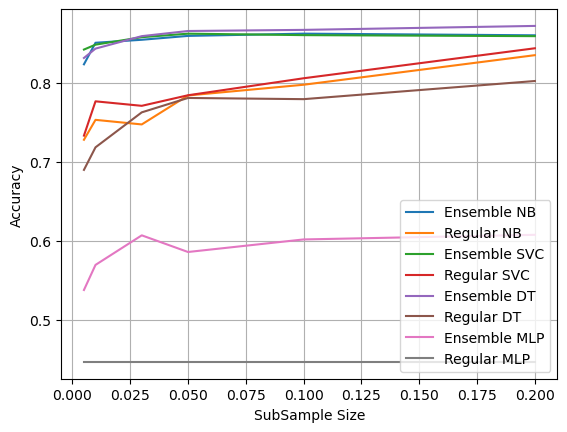

In [9]:
%matplotlib inline
import matplotlib.pyplot as plt

plt.plot(sample_sizes, [a[0] for a in results_ensemble['NB']], label='Ensemble NB')
plt.plot(sample_sizes, [a[0] for a in results_regular['NB']], label='Regular NB')
plt.plot(sample_sizes, [a[0] for a in results_ensemble['SVC']], label='Ensemble SVC')
plt.plot(sample_sizes, [a[0] for a in results_regular['SVC']], label='Regular SVC')
plt.plot(sample_sizes, [a[0] for a in results_ensemble['DT']], label='Ensemble DT')
plt.plot(sample_sizes, [a[0] for a in results_regular['DT']], label='Regular DT')
plt.plot(sample_sizes, [a[0] for a in results_ensemble['MLP']], label='Ensemble MLP')
plt.plot(sample_sizes, [a[0] for a in results_regular['MLP']], label='Regular MLP')
plt.xlabel('SubSample Size')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.grid()
plt.show()

Clearly, the 100 ensemble models outperform the regular classifiers for every subsample level. The performance gap closes as the subsample becomes larger. The ensemble classifiers achieve a high level of performance for small subsample sizes. The ensemble Decision Tree has the best performance. Both versions of the Multi-layer Perceptron (MCP) model have the worst performance. The analysis below investigates how the performance can be improved for ensemble MLP model. First, larger subsamples are tested. Then, narrowing the fields available for fitting using feature-target correlations is tested. Below are the results.   

In [10]:
%%time
# Collect MLP metrics for larger subsamples.
eval_df = X_onehot.values
results_mlp_1 = {'MLP':[]}
num_estimators = 100
n_flds_to_use = 5
sample_sizes = [0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 0.99]
for frac in sample_sizes:
    subsample = frac  # Fraction of training data to sample and fit with.
    acc = eval_ensemble('MLP', eval_df, y, 10, num_estimators, n_flds_to_use, _subsample=subsample)
    print_acc('MLP', acc, results_mlp_1, print_results=False)

CPU times: total: 31min 7s
Wall time: 45min 4s


In [11]:
%%time
# Collect MLP metrics for larger subsamples and feature selection using correlation.
"""
For a pd.DataFrame and a target in it, return correlations
  of other varialbles with target. 
"""
def ranker_correlation( _data, _target):
    corrs = _data.corr()
    tgt = corrs[[_target]].abs().drop([_target],axis=0)
    return tgt.sort_values(by=[_target], ascending=False)

df = X_onehot.copy()
df[target] = y
rank = ranker_correlation( df, target)
high_corr_cols = list(rank[rank[target] >= 0.3].index)
print(f'Features with corrletaion >= 0.3: {len(high_corr_cols)}')
eval_df = X_onehot[high_corr_cols].values
results_mlp_2 = {'MLP':[]}
sample_sizes = [0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 0.99]
for frac in sample_sizes:
    subsample = frac  # Fraction of training data to sample and fit with.
    acc = eval_ensemble('MLP', eval_df, y, 10, num_estimators, n_flds_to_use, _subsample=subsample)
    print_acc('MLP', acc, results_mlp_2, print_results=False)

Features with corrletaion >= 0.3: 10
CPU times: total: 24min 21s
Wall time: 25min 50s


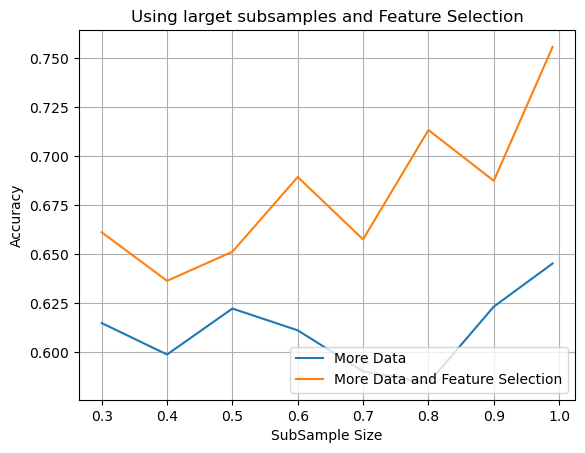

In [12]:
plt.plot(sample_sizes, [a[0] for a in results_mlp_1['MLP']], label='More Data')
plt.plot(sample_sizes, [a[0] for a in results_mlp_2['MLP']], label='More Data and Feature Selection')
plt.xlabel('SubSample Size')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.title('Using larget subsamples and Feature Selection')
plt.grid()
plt.show()

The best MLP performance occurs with models fitted with larger samples and feature selection using correlation. However, this performance is still inferior to the other three classifiers.

# Conclusions

- For smaller sample sizes, ensemble classifiers delivers superior performance than individual classifiers. 
- The performance gap between the two closes as larger samples are used.
- For ensemble classifiers, high performance occurs at very small samples sizes with performance only increasing marginally for larger samples sizes. The performance of ensemble classifiers using small samples rivals regular classifiers trained with all the data, including the base-line Logistic Regression model created at the beginning of this analysis.
- The Multi-Layer Perceptron (MLP) model needs more data relative to the other classifiers to deliver comparable performance. 
- MLP benefits from using feature correlation with the target variable to do feature selection but more research needs to be done to use this optimally.   